In [106]:
import torch
import torch.nn as nn
# Adding padding to our dataset (train and test models)
import tensorflow as tf
import numpy as np
from Code.Preprocess.DataPreparation import dataPrepare

In [107]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [108]:
data = dataPrepare()
X_train, X_test, y_train, y_test =  data.Vectorizer('/Users/aneruthmohanasundaram/Documents/GitHub/Spam_Detection/Code/Data/Youtube01-Psy.csv')

In [109]:
# Adding the padding to our sparse matrix
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train.todense())
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test.todense())

In [110]:
# make training and test sets in torch
x_train = torch.from_numpy(X_train).type(torch.Tensor)
x_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train.to_numpy()).type(torch.Tensor)
y_test = torch.from_numpy(y_test.to_numpy()).type(torch.Tensor)

In [111]:
(y_train.size(),x_train.size())

(torch.Size([245]), torch.Size([245, 1, 1010]))

In [114]:
input_dim = 1010
hidden_dim = 28
num_layers = 4
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1010, 28, num_layers=4, batch_first=True)
  (fc): Linear(in_features=28, out_features=1, bias=True)
)
18
torch.Size([112, 1010])
torch.Size([112, 28])
torch.Size([112])
torch.Size([112])
torch.Size([112, 28])
torch.Size([112, 28])
torch.Size([112])
torch.Size([112])
torch.Size([112, 28])
torch.Size([112, 28])
torch.Size([112])
torch.Size([112])
torch.Size([112, 28])
torch.Size([112, 28])
torch.Size([112])
torch.Size([112])
torch.Size([1, 28])
torch.Size([1])


In [133]:
def model_accuracy(predict,y):
  true_predict=(predict==y).to_numpy()
  acc=true_predict.sum()/len(true_predict)
 
  return acc
X,y = data.deepLearningInput('/Users/aneruthmohanasundaram/Documents/GitHub/Spam_Detection/Code/Data/Youtube01-Psy.csv')
# Train model
#####################
num_epochs = 1000
loss_val  = np.zeros(num_epochs)
acc_val  = np.zeros(num_epochs)

for t in range(num_epochs):
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print(f"Epoch {t} MSE is {loss.item()}")
    loss_val[t] = loss.item()
    
    pred = torch.max(y_train_pred, 1)[1].eq(y_train).sum()
    # pred = model_accuracy(y_train_pred,y)
    if t % 10 == 0 and t !=0:
        print(f"Epoch {t} accuracy(%) is {(100*pred/len(y_train)).item()}")
    acc_val[t] = (100*pred/len(y_train)).item()
    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch 10 MSE is 0.24989591538906097
Epoch 10 accuracy(%) is 48.979591369628906
Epoch 20 MSE is 0.24989591538906097
Epoch 20 accuracy(%) is 48.979591369628906
Epoch 30 MSE is 0.24989591538906097
Epoch 30 accuracy(%) is 48.979591369628906
Epoch 40 MSE is 0.2498958557844162
Epoch 40 accuracy(%) is 48.979591369628906
Epoch 50 MSE is 0.249895840883255
Epoch 50 accuracy(%) is 48.979591369628906
Epoch 60 MSE is 0.24989591538906097
Epoch 60 accuracy(%) is 48.979591369628906
Epoch 70 MSE is 0.24989591538906097
Epoch 70 accuracy(%) is 48.979591369628906
Epoch 80 MSE is 0.2498958855867386
Epoch 80 accuracy(%) is 48.979591369628906
Epoch 90 MSE is 0.2498958706855774
Epoch 90 accuracy(%) is 48.979591369628906
Epoch 100 MSE is 0.24989627301692963
Epoch 100 accuracy(%) is 48.979591369628906
Epoch 110 MSE is 0.2499358355998993
Epoch 110 accuracy(%) is 48.979591369628906
Epoch 120 MSE is 0.2499096393585205
Epoch 120 accuracy(%) is 48.979591369628906
Epoch 130 MSE is 0.24989649653434753
Epoch 130 accura

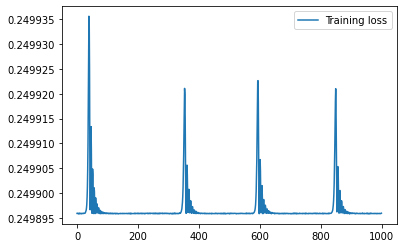

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss_val, label="Training loss")
plt.legend()
plt.show()

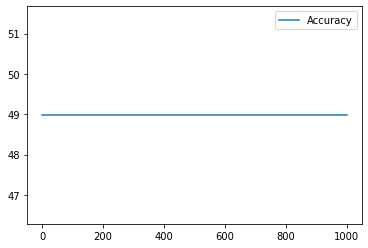

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(acc_val, label="Accuracy")
plt.legend()
plt.show()

In [1]:
f'{0}Aneruth'

'0Aneruth'